In [1]:
import pandas as pd 
import numpy as np 
import re
from tqdm import tqdm

In [2]:
# %%capture
# !pip install transformers --upgrade
# !pip install mosestokenizer
# !pip install sentencepiece
# !pip install ast

In [3]:
import torch
import transformers
from transformers import BertForSequenceClassification, XLMRobertaForSequenceClassification, AdamW, BertConfig, BertTokenizer, XLMRobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
# from google.colab import drive
import re
from bs4 import BeautifulSoup

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/option-generation/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# drive.mount("/content/drive", force_remount=True)

In [6]:
'''
Construct object in BERT sentiment classifier class
'''
sentiment_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden states.
)

sentiment_model.to(device) # Puts model on GPU

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [7]:
'''
Load pretrained sentiment model parameters
'''
sentiment_model.load_state_dict(torch.load("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/Testing/OptionGeneration/Model/English_sentiment_model.pt", map_location=torch.device('cuda:3')), strict=False)


_IncompatibleKeys(missing_keys=['bert.embeddings.position_ids'], unexpected_keys=[])

In [8]:
sentiment_model.eval() # Put model in inference (as opposed to training) mode

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [9]:
'''
Load tokenizer for sentiment model
'''
sentiment_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [10]:
# gets the text into the format we want
def clean_tweet(tweet):
#     tweet = BeautifulSoup(tweet, "lxml").get_text() # turns xml-formatted text into regular text
    tweet = re.sub(r"@[A-Za-z0-9]+", " ", tweet) # gets rid of all user references in tweets (i.e. "@username")
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", " ", tweet) # gets rid of URLs
    tweet = re.sub(r"[^A-Za-z.!?áéíóúüñ¿ÁÉÍÓÚÜÑ']", " ", tweet) # gets rid of any non-standard characters in the tweets
    tweet = re.sub(r" +", " ", tweet) # replaces all excess whitespace with a single space

    return tweet # gives us our cleaned tweet

In [11]:
def predict_sentiment(tweet):

    '''
    Predict the sentiment of an input text
    '''
    
    tweet = clean_tweet(tweet)
    tweet_input_id = []
    tweet_attention_mask = []

    tweet_dict = sentiment_tokenizer.encode_plus(
                            tweet,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            truncation=True,           # Explicitly enable truncation
                            padding = 'max_length',
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

    # Add the encoded sentence to the list.    
    tweet_input_id.append(tweet_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    tweet_attention_mask.append(tweet_dict['attention_mask'])

    # Convert the lists into tensors.
    tweet_input_id = torch.cat(tweet_input_id, dim=0)
    tweet_attention_mask = torch.cat(tweet_attention_mask, dim=0)

    tweet_data = TensorDataset(tweet_input_id, tweet_attention_mask)
    
    tweet_dataloader = DataLoader(tweet_data)
    
    for data in tweet_dataloader:
        tweet_input_id = data[0].to(device=torch.device('cuda'))
        tweet_attention_mask = data[1].to(device=torch.device('cuda'))
    
    tweet_logits = sentiment_model(tweet_input_id, token_type_ids=None, attention_mask=tweet_attention_mask)
    
    tweet_logits = tweet_logits[0].detach().cpu().numpy()

    tweet_logits = torch.Tensor(tweet_logits)

    softmax = torch.nn.Softmax(dim=1)
    prob_dist = softmax(tweet_logits)

    sentiment_pred = prob_dist.tolist()

    sentiment_pred = sentiment_pred[0][1]

    return sentiment_pred

In [12]:
# test 
predict_sentiment("This is bad.")

0.01685626618564129

In [13]:
#Another version of semantic distance here 
# !pip install transformers
# !pip install sentence_transformers 
from transformers import pipeline 

In [14]:
#sentence level embeddings 

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

#example use 
# sentences = ["Hello World", "Hallo Welt"]
# embeddings = model.encode(sentences)
# print(embeddings)

In [15]:
generations = pd.read_csv('https://raw.githubusercontent.com/gokulsrin/PossibilityGeneration/main/Full/modifiedgenerationfull.csv')

In [16]:
import math 
from scipy import spatial 
# def dist(r1, r2): #euclidean distance
#   r1 = np.array(r1)
#   r2 = np.array(r2)
#   return np.linalg.norm((r1 - r2), ord=2)
def dist(r1, r2): #cosine distance
    r1 = np.array(r1)
    r2 = np.array(r2)
    return spatial.distance.cosine(r1, r2)
# def dist(r1, r2): #manhattan distance
#   r1 = np.array(r1)
#   r2 = np.array(r2)
#   return np.linalg.norm((r1 - r2), ord=1)

# **Total Semantic Exploration (adjusted) vs Average Sentiment**

In [17]:
#semantic exploration vs average sentiment
exploration = {}
individual_sentiment = {}
for id, group in tqdm(generations.groupby("id")):
    exploration[id] = 0
    individual_sentiment[id] = []
    len_responses = 0
    for vign, group2 in group.groupby("vignette_name"):
        embeddings = []
        for response, group3 in group2.groupby("response"):
            if not pd.isna(response):
                embeddings.append(model.encode(response))
                individual_sentiment[id].append(predict_sentiment(response))
        len_responses += len(embeddings)
        for i in range(len(embeddings)):
            for j in range(i+1, len(embeddings)):
                exploration[id] += dist(embeddings[i], embeddings[j])
    exploration[id] /= len_responses

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [02:31<00:00,  1.30it/s]


In [18]:
#find average sentiment 
for id in individual_sentiment:
    individual_sentiment[id] = sum(individual_sentiment[id])/len(individual_sentiment[id])

In [19]:
x = []
y = []
for id in exploration:
    if .5 < individual_sentiment[id] < .9:
        x.append(individual_sentiment[id])
        y.append(exploration[id])

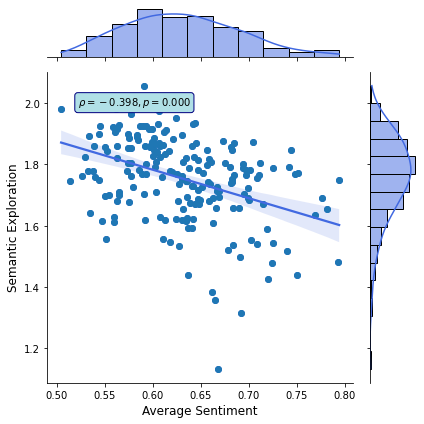

In [20]:
#display adjusted exploration vs average sentiment 
import seaborn as sns 
import scipy.stats as stats
import matplotlib.pyplot as plt

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Average Sentiment', ylabel='Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [21]:
#save these data into a csv

In [22]:
#try to combine the above two plots 
import plotnine
from plotnine import ggplot, aes
# package for plot scales
from mizani.formatters import comma_format # (thousands seperator format)

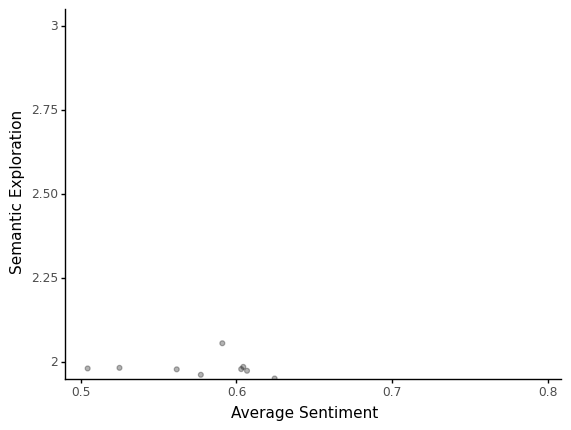

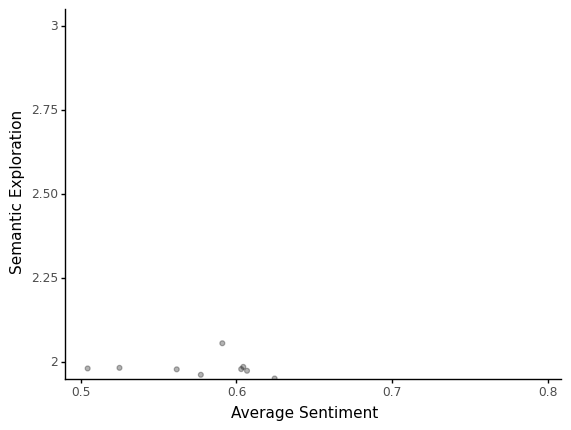

In [23]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Average_Sentiment", "Semantic_Exploration"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Average_Sentiment', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5) + 
 plotnine.xlab("Average Sentiment") +
 plotnine.ylab("Semantic Exploration") + 
 plotnine.coords.coord_cartesian(ylim=(2,3)) +
 plotnine.theme_classic()
).draw()




#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))

In [24]:
def average_embedding(embeddings):
    df = pd.DataFrame(embeddings)
    df = df.mean(axis=0)
    return df.values.tolist()

# **Total Semantic Exploration vs Generation Number**

In [25]:
generations

Unnamed: 0 vignette_name  generation_number  generation_time  \
0               0         Erica                  1                0   
1               1         Erica                  2                0   
2               2         Erica                  3                0   
3               3         Erica                  4                0   
4               4         Erica                  5                0   
...           ...           ...                ...              ...   
12180       12180       Cameron                  2                0   
12181       12181       Cameron                  3                0   
12182       12182       Cameron                  4                0   
12183       12183       Cameron                  5                0   
12184       12184       Cameron                  6                0   

                                                response  reflection_score  \
0                               break one of the windows                 0   
1                                        call the police                 0   
2                                    alert mall security                 0   
3                                ask a stranger for help                 0   
4                                               call 911                 0   
...                                                  ...               ...   
12180                                       Tell her no.                 0   
12181  Take her as far as you are going and drop her off                 0   
12182                                         Call a cab                 0   
12183                    Ask someone else at the station                 0   
12184  Tell her you are going in the opposite direction.                 0   

                     id  
0      YX5fuO4VpL3Et7bB  
1      YX5fuO4VpL3Et7bB  
2      YX5fuO4VpL3Et7bB  
3      YX5fuO4VpL3Et7bB  
4      YX5fuO4VpL3Et7bB  
...                 ...  
12180  1SczUqX7VCwAfGkB  
12181  1SczUqX7VCwAfGkB  
12182  1SczUqX7VCwAfGkB  
12183  1SczUqX7VCwAfGkB  
12184  1SczUqX7VCwAfGkB  

[12185 rows x 7 columns]

In [26]:
# Real semantic exploration 
#exploration and answers tally average
exploration = {}
answers = {}
#exp and nums tally the individual explorations
exp = []
nums = []
for id, group in tqdm(generations.groupby("id")):
      for pnum, group2 in group.groupby("generation_number"):
        if pnum not in exploration: 
            exploration[pnum] = []
          # answers[pnum] = 0
        embeddings = []
        for response, group3 in group2.groupby("response"):
            response = group3['response'].to_list()[0]
            if not pd.isna(response):
                embeddings.append(model.encode(response).tolist())
        # answers[pnum] += len(embeddings)
        if len(embeddings) > 0:
            e = 0
            for i in range(len(embeddings)):
                for j in range(i+1, len(embeddings)):
                    e += dist(embeddings[i], embeddings[j])
            exploration[pnum].append(e/len(embeddings))
            exp.append(e/len(embeddings))
            nums.append(pnum)

x_avg = []
y_avg = []
for num in exploration:
    x_avg.append(num)
    y_avg.append(sum(exploration[num])/len(exploration[num]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:59<00:00,  3.30it/s]


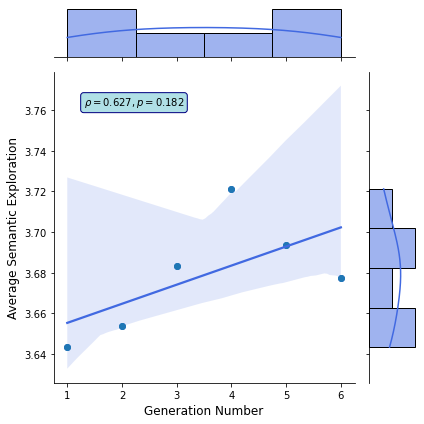

In [27]:
#plotting for stats
g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [28]:
d = pd.DataFrame(data=[nums,exp])
d = d.T
d.columns = ["Generation_Number", "Semantic_Exploration"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Semantic_Exploration"]

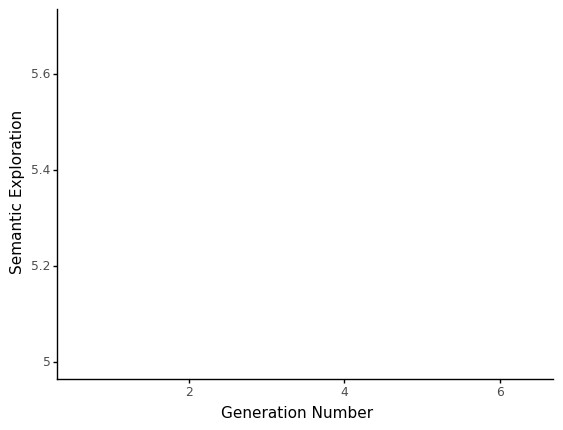

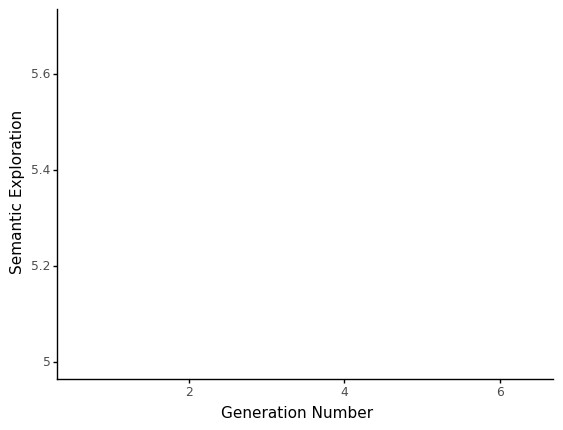

In [29]:
errors = []
for num, group in d.groupby("Generation_Number"):
    errors.append(group.std()["Semantic_Exploration"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Semantic_Exploration-yerr",ymax="Semantic_Exploration+yerr"), color="red",width=.15) + 
 plotnine.ylab("Semantic Exploration") +
 plotnine.xlab("Generation Number") +
  plotnine.coords.coord_cartesian(ylim=(5,5.70)) +
 plotnine.theme_classic()
  ).draw()

In [30]:
def total_variation(e):
    variation = 0
    count = 0
    for i in range(len(e)):
        for j in range(i+1, len(e)):
            variation += dist(e[i], e[j])
            count += 1
            if count%10000==0:
                print("done")
    return variation

# **Semantic Dissimilarity vs Generation Number**

In [31]:
# Semantic space similarity vs possibiltiy number (pairwise sim between all avg. embedding vectors)
vectordic = {}
for id, group in tqdm(generations.groupby("id")):
    for pnum, group2 in group.groupby("generation_number"):
        if pnum not in vectordic:
            vectordic[pnum] = []
        embeddings = []
        for generation in group2['response']:
            if not pd.isna(generation):
                embeddings.append(model.encode(generation))
        embeddings = pd.DataFrame(embeddings)
        embeddings = embeddings.mean(axis=0)
        embeddings = embeddings.values.tolist()
        if len(embeddings) > 0:
            vectordic.get(pnum).append(embeddings)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [01:05<00:00,  3.01it/s]


In [32]:
#semantic space dissimilarity vs generation nums
similarity = []
nums = []
avg_dic = {}
for num in tqdm(vectordic):
    avg_dic[num] = []
    for i in range(len(vectordic.get(num))):
        for j in range(i+1, len(vectordic.get(num))):
            nums.append(num)
            s = dist(vectordic.get(num)[i], vectordic.get(num)[j])
            similarity.append(s)
            avg_dic[num].append(s)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


In [33]:
# remove invalid data - why would the distance between two distinct localizing vectors be 0? 
x = nums
y = similarity
i = 0 
avg_dic = {}
while i < len(x):
  if y[i] == 0:
    y.pop(i)
    x.pop(i)
    i -= 1
  else:
    if x[i] not in avg_dic:
      avg_dic[x[i]] = []
    avg_dic[x[i]].append(y[i])
  i += 1
x_avg = []
y_avg = []
for num in avg_dic:
  avg_dic[num] = sum(avg_dic[num])/len(avg_dic[num])
  x_avg.append(num)
  y_avg.append(avg_dic[num])

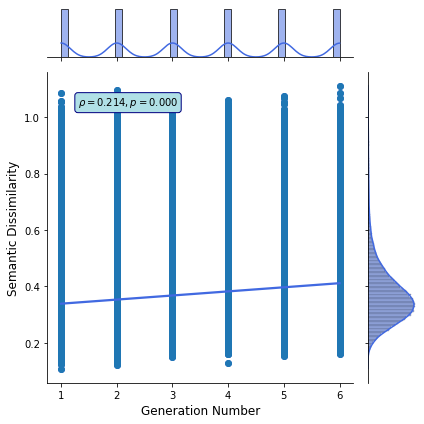

In [34]:
#plotting to find stats 
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

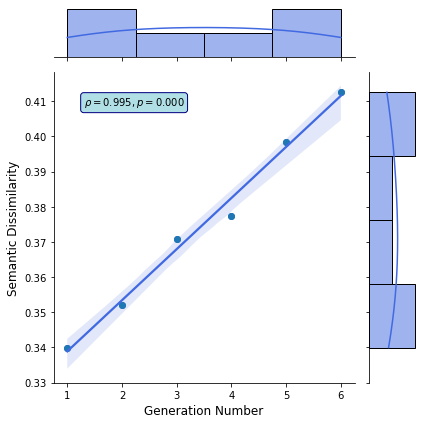

In [35]:
#plotting to find stats 

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

In [36]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Semantic_Dissimilarity"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Semantic_Dissimilarity"]

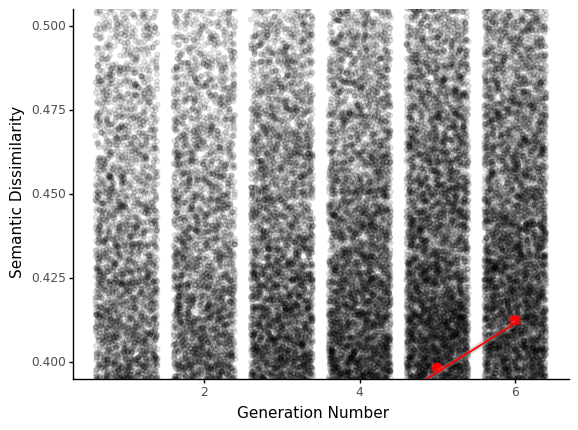

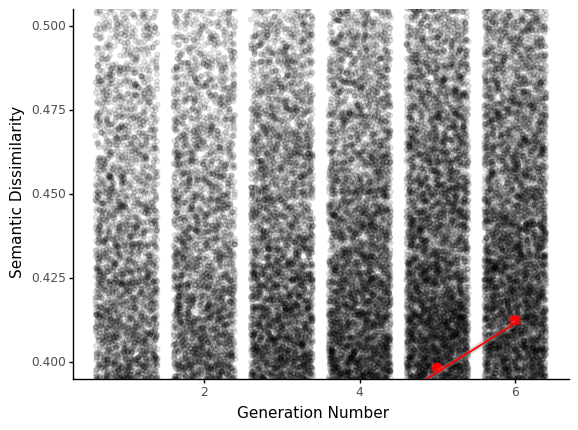

In [37]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Semantic_Dissimilarity"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Semantic_Dissimilarity'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.1) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Semantic_Dissimilarity-yerr",ymax="Semantic_Dissimilarity+yerr"), color="red",width=.15) + 
 plotnine.ylab("Semantic Dissimilarity") +
 plotnine.xlab("Generation Number") +
  plotnine.coords.coord_cartesian(ylim=(.4,.5)) +
 plotnine.theme_classic()
  ).draw()

# **Subjective Goodness vs Generation Number**

In [38]:
#average goodness rating per possibility 
scores = [[] for i in range(6)]
nums = [i for i in range(6)]

#all of the ratings 
s = []
n = []

for pnum, group1 in generations.groupby("generation_number"):
  for score in group1['reflection_score']:
    scores[pnum-1].append(score)
    s.append(score)
    n.append(pnum)

for i in range(len(scores)):
  scores[i] = sum(scores[i])/len(scores[i])

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/option-generation/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


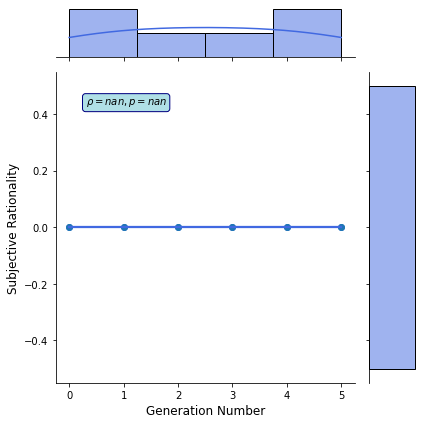

In [39]:
#plotting for stats
x_avg = np.array(nums) 
y_avg = np.array(scores)

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Subjective Rationality', size=12)
plt.tight_layout()
plt.show()

In [40]:
d = pd.DataFrame(data=[n,s])
d = d.T
d.columns = ["Generation_Number", "Generation_Goodness"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Goodness"]

errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Goodness"]/(len(group["Generation_Goodness"])**.5))
d2["yerr"] = errors


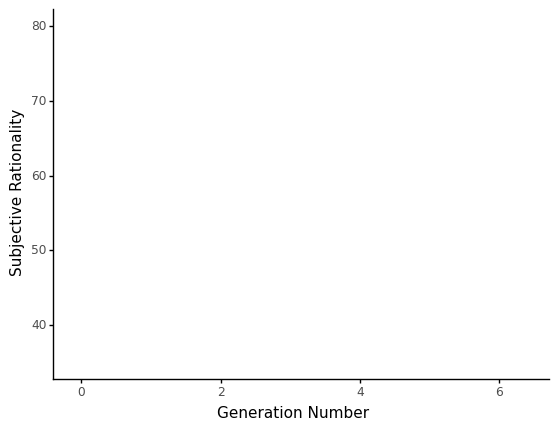

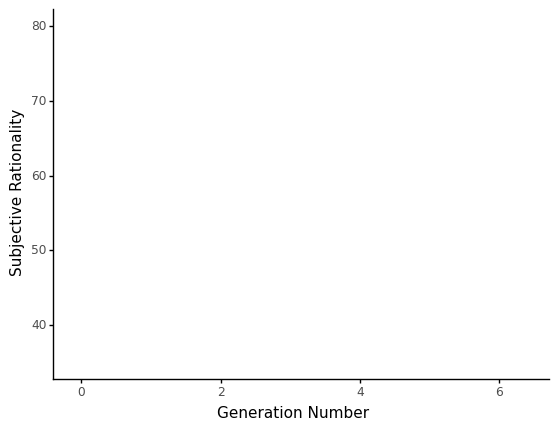

In [41]:
scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Generation_Goodness'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Goodness-yerr",ymax="Generation_Goodness+yerr"), color="red",width=.15) + 
 plotnine.ylab("Subjective Rationality") +
 plotnine.xlab("Generation Number") + 
 plotnine.theme_classic()  +
 plotnine.coords.coord_cartesian(ylim=(35,80)) 
 ).draw()

# **Generation Sentiment vs Generation Number**

In [42]:
#generation sentiment vs generation number

sentiment = []
nums = []
avg_sentiment = {}
for id, participant in tqdm(generations.groupby('id')):
  for pos_num, group in participant.groupby('generation_number'):
    if pos_num not in avg_sentiment:
      avg_sentiment[pos_num] = []
    for generation in group['response']:
      if not pd.isna(generation):
        s = predict_sentiment(generation)
        sentiment.append(s)
        nums.append(pos_num)
        avg_sentiment[pos_num].append(s)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [01:39<00:00,  1.98it/s]


In [43]:
x = nums
y = sentiment

x_avg = []
y_avg = []
for num in avg_sentiment:
  x_avg.append(num)
  y_avg.append(sum(avg_sentiment[num])/len(avg_sentiment[num]))

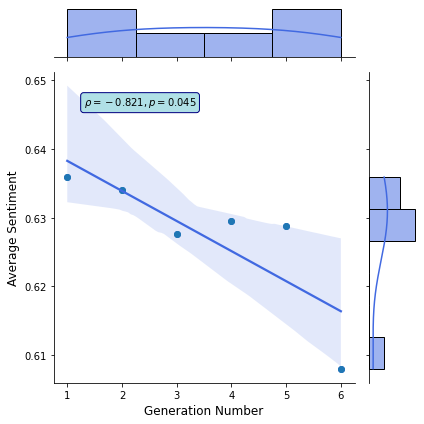

In [44]:
#plotting for stats 
g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Sentiment', size=12)
plt.tight_layout()
plt.show()

In [45]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Generation_Sentiment"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Sentiment"]

errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Sentiment"]/(len(group["Generation_Sentiment"])**.5))
d2["yerr"] = errors


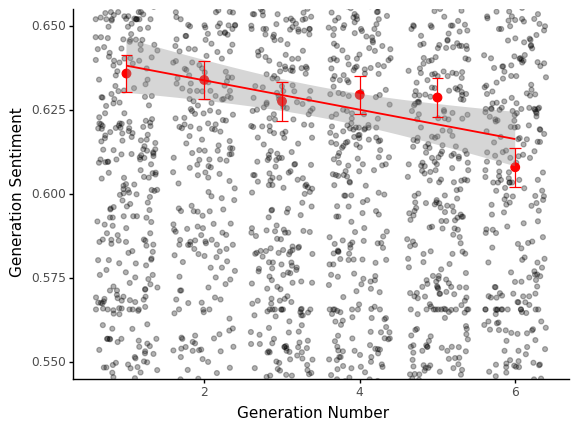

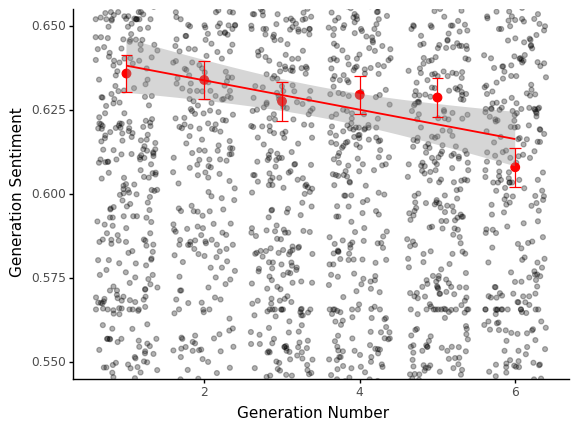

In [46]:
scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Generation_Sentiment'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Sentiment-yerr",ymax="Generation_Sentiment+yerr"), color="red",width=.15) + 
 plotnine.ylab("Generation Sentiment") +
 plotnine.xlab("Generation Number") + 
 plotnine.theme_classic() +
 plotnine.coords.coord_cartesian(ylim=(.55,.65)) 
).draw()

# **Generation Concreteness vs Generation Number**

In [47]:
concreteness = pd.read_csv("https://raw.githubusercontent.com/gokulsrin/PossibilityGeneration/main/Misc/Concreteness_ratings_Brysbaert_et_al_BRM.csv")

In [48]:
#create concreteness dict
concreteness_dict = {}
for word, group in concreteness.groupby("Word"):
  rating = group["Conc.M"].values[0]
  concreteness_dict[word] = rating

In [49]:
#figure out if later generations are more or less concrete 
import string 

conc = []
nums = []
cdic = {}
for id, group in tqdm(generations.groupby("id")):
  for vign, group2 in group.groupby("vignette_name"):
    for num, group3 in group2.groupby("generation_number"):
      for response, group4 in group3.groupby("response"):
        if not pd.isna(response):
          response = response.translate(str.maketrans('', '', string.punctuation))
          score = []
          l = len(response.split(" "))
          for word in response.split(" "):
            if word in concreteness_dict:
              score.append(concreteness_dict[word])
          if len(score) > 0:
            score = sum(score)/len(score)
            # score = (sum(score)/len(score))/l
            conc.append(score)
            nums.append(num)
            if num not in cdic:
              cdic[num] = []
            cdic[num].append(score)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:05<00:00, 35.38it/s]


In [50]:
#find averages in concreteness differences
x_avg = []
y_avg = [] 
for key in cdic:
  cdic[key] = sum(cdic[key])/len(cdic[key])
  x_avg.append(key)
  y_avg.append(cdic[key])

print(cdic)

{1: 2.7767954178691747, 2: 2.755848183513439, 3: 2.719223207388812, 4: 2.7368169596840737, 5: 2.718266124602115, 6: 2.7033914427220993}


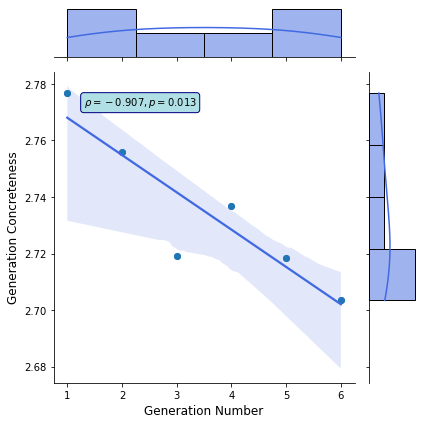

In [51]:
#just for stats

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Generation Concreteness', size=12)
plt.tight_layout()
plt.show()

In [52]:
d = pd.DataFrame(data=[nums,conc])
d = d.T
d.columns = ["Generation_Number", "Generation_Concreteness"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Concreteness"]

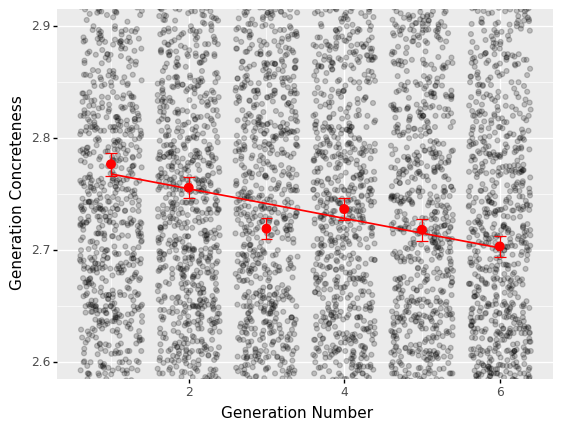

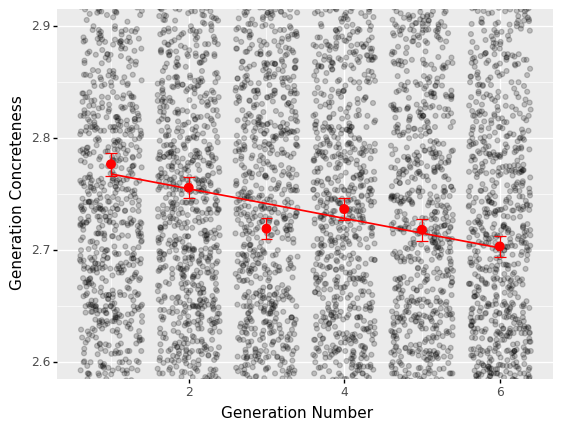

In [53]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Concreteness"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d2, mapping=aes(x='Generation_Number', y='Generation_Concreteness', ymin=2.7))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.2) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.70, color="red", se=False) + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Concreteness-yerr",ymax="Generation_Concreteness+yerr"), color="red",width=.15) + 
 plotnine.ylab("Generation Concreteness") +
 plotnine.xlab("Generation Number") + 
  plotnine.coords.coord_cartesian(ylim=(2.6,2.9))
  ).draw()

# **Concreteness vs Semantic Relatedness**

In [54]:
#bin the generations based on concreteness 
gens = {}
for response, group in tqdm(generations.groupby("response")):
    response = response.translate(str.maketrans('', '', string.punctuation))
    score = []
    l = len(response.split(" "))
    for word in response.split(" "):
      if word in concreteness_dict:
        score.append(concreteness_dict[word])
    if len(score) > 0:
      score = sum(score)/len(score)
      gens[response] = score

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10627/10627 [00:00<00:00, 77491.35it/s]


In [55]:
#bin all of the responses : num bins = 10 
gens = dict(sorted(gens.items(), key=lambda item: item[1]))
len(gens)

10385

In [56]:
nbins = 100
bins = [[] for j in range(nbins)]
i = 0 
for item in gens:
  if i//int(len(gens)/nbins) < nbins:
    bins[i//int(len(gens)/nbins)].append((item, gens[item]))
  i += 1

In [57]:
from tqdm import tqdm

In [58]:
similarity = {}
for b in tqdm(range(len(bins))):
  if b not in similarity: 
    similarity[b] = []
  bin = bins[b]
  embeddings = {}
  for response in bin:
    response = response[0]
    embeddings[response] = model.encode(response)
  for i in range(len(bin)):
    for j in range(i+1, len(bin)):
      similarity[b].append(dist(embeddings[bin[i][0]], embeddings[bin[j][0]]))
similarity 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


{0: [0.869443729519844,
  0.8769991472363472,
  0.7897407710552216,
  1.020667104050517,
  0.8410822004079819,
  0.882777750492096,
  0.9761770851910114,
  0.9397673904895782,
  1.1089411452412605,
  0.854390561580658,
  0.9009544104337692,
  0.8130744993686676,
  0.3351476788520813,
  0.8887520879507065,
  0.8887520879507065,
  0.8615250736474991,
  0.8487164229154587,
  0.9777178037911654,
  0.7347153723239899,
  0.8229347169399261,
  0.8696336597204208,
  0.8696336597204208,
  0.8696336597204208,
  0.731858640909195,
  1.0459251552820206,
  0.9209762737154961,
  0.7476903796195984,
  0.8952797651290894,
  0.9164058864116669,
  1.0011838786303997,
  0.8486383259296417,
  0.5529172122478485,
  0.8372717350721359,
  0.8439209163188934,
  0.9351359978318214,
  0.8094782829284668,
  0.8808055371046066,
  0.9945420916192234,
  0.7904423624277115,
  0.8838883265852928,
  0.9454113841056824,
  1.0340388268232346,
  0.9236993193626404,
  0.8983891904354095,
  0.746709018945694,
  0.724947601

In [59]:
buckets = {}
for key in similarity:
  buckets[key] = sum(similarity[key])/len(similarity[key])

In [60]:
x_avg = []
y_avg = []

for key in buckets:
  x_avg.append(key)
  y_avg.append(buckets[key])

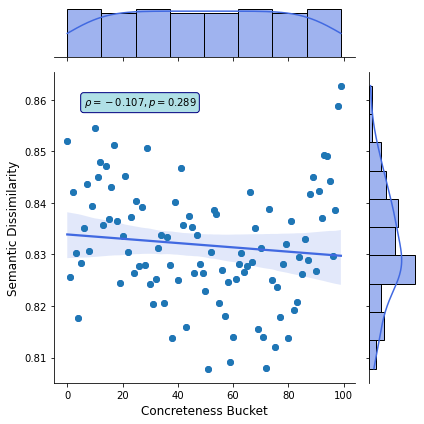

In [61]:
# to be clear, higher buckets have higher concreteness. 

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Concreteness Bucket', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

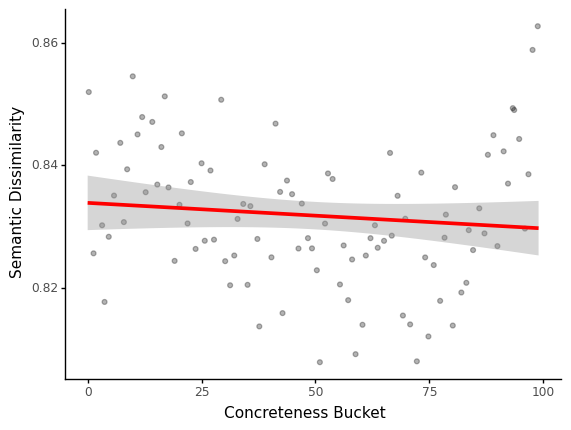

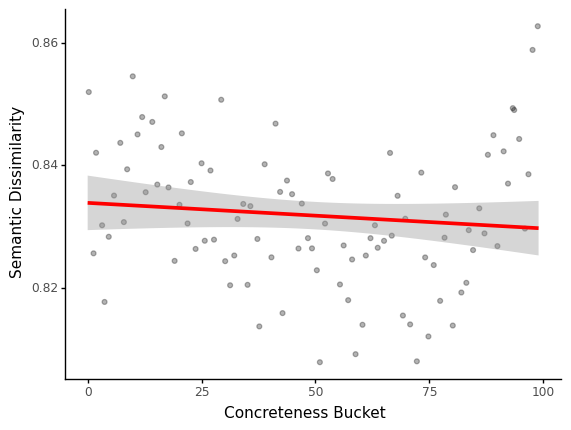

In [62]:
d = pd.DataFrame(data=[x_avg,y_avg])
d = d.T
d.columns = ["Concreteness_Bucket", "Semantic_Dissimilarity"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Concreteness_Bucket', y='Semantic_Dissimilarity'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Concreteness Bucket") +
 plotnine.ylab("Semantic Dissimilarity") + 
 plotnine.theme_classic()
).draw()

#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


# **Semantic Exploration vs Average Concreteness**

In [63]:
# semantic exploration 
exploration = {}
for id, group in tqdm(generations.groupby("id")):
    exploration[id] = 0
    len_responses = 0
    for vign, group2 in group.groupby("vignette_name"):
        embeddings = []
    for response, group3 in group2.groupby("response"):
        if not pd.isna(response):
            embeddings.append(model.encode(response))
    len_responses += len(embeddings)
    for i in range(len(embeddings)):
        for j in range(i+1, len(embeddings)):
            exploration[id] += dist(embeddings[i], embeddings[j])
    exploration[id] /= len_responses

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:06<00:00, 28.38it/s]


In [64]:
#determine avg concreteness 
id_concreteness = {}
for id, group in tqdm(generations.groupby("id")):
  for response, group2 in group.groupby("response"):
    response = response.translate(str.maketrans('', '', string.punctuation))
    score = []
    l = len(response.split(" "))
    for word in response.split(" "):
      if word in concreteness_dict:
        score.append(concreteness_dict[word])
    if len(score) > 0:
      if id not in id_concreteness:
        id_concreteness[id] = []
      score = sum(score)/len(score)
      id_concreteness[id].append(score)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:00<00:00, 737.23it/s]


In [65]:
for id in id_concreteness:
  id_concreteness[id] = sum(id_concreteness[id])/len(id_concreteness[id])

In [66]:
x = []
y = []
for id in id_concreteness:
  if id in exploration:
    x.append(id_concreteness[id])
    y.append(exploration[id])

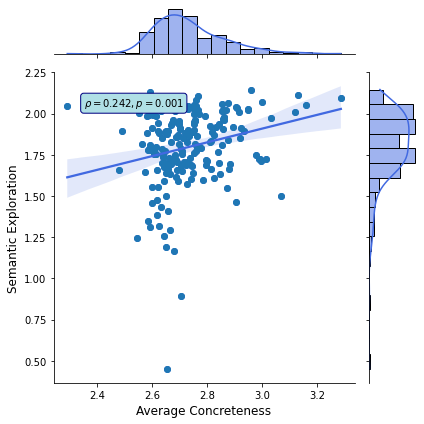

In [67]:
#display adjusted exploration vs average sentiment 
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Average Concreteness', ylabel='Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

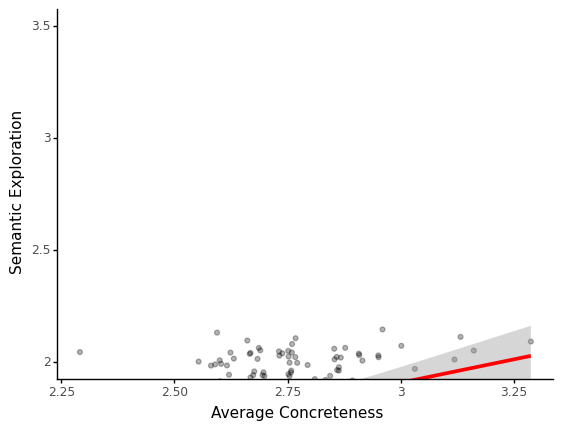

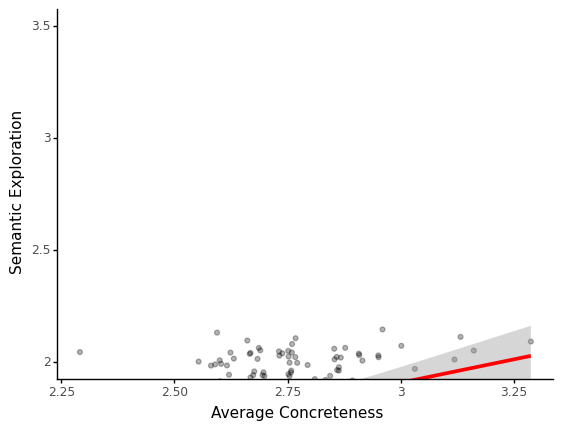

In [68]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Average_Concreteness", "Semantic_Exploration"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Average_Concreteness', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Average Concreteness") +
 plotnine.ylab("Semantic Exploration") + 
 plotnine.theme_classic() + 
 plotnine.coords.coord_cartesian(ylim=(2,3.5))
).draw()

#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


# **Generation Concreteness vs Subjective Score**

In [69]:
concreteness = []
subjective = []
for response, group in tqdm(generations.groupby("response")):
  response = response.translate(str.maketrans('', '', string.punctuation))
  score = []
  l = len(response.split(" "))
  for word in response.split(" "):
    if word in concreteness_dict:
      score.append(concreteness_dict[word])
  if len(score) > 0 :
    score = sum(score)/len(score)
    concreteness.append(score)
    subjective.append(list(group["reflection_score"])[0])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10627/10627 [00:00<00:00, 15831.96it/s]


/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/option-generation/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


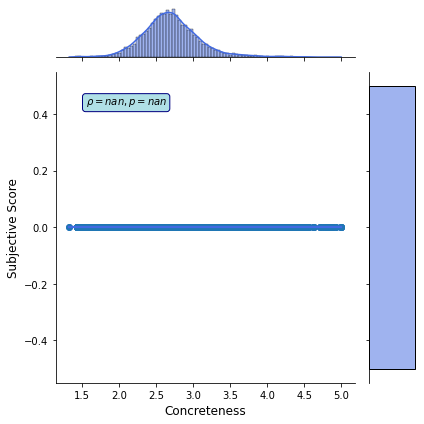

In [70]:
x = concreteness
y = subjective

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Concreteness', ylabel='Subjective Score', size=12)
plt.tight_layout()
plt.show()

# **Generation Concreteness vs Generation Sentiment**

In [71]:
concreteness = []
sentiment = []
for response, group in tqdm(generations.groupby("response")):
  response = response.translate(str.maketrans('', '', string.punctuation))
  score = []
  l = len(response.split(" "))
  for word in response.split(" "):
    if word in concreteness_dict:
      score.append(concreteness_dict[word])
  if len(score) > 0:
    score = sum(score)/len(score)
    concreteness.append(score)
    sentiment.append(predict_sentiment(response))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10627/10627 [01:32<00:00, 115.28it/s]


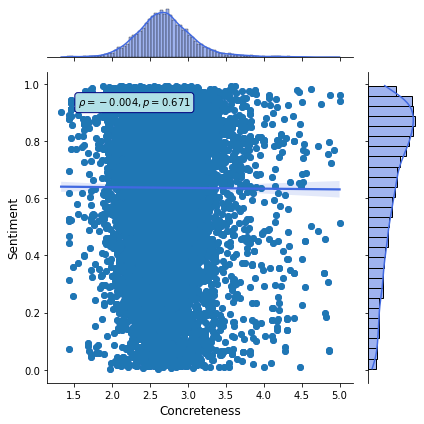

In [72]:
x = concreteness
y = sentiment

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Concreteness', ylabel='Sentiment', size=12)
plt.tight_layout()
plt.show()

# Heatmap Analysis 
* The goal here is twofold: 
1. Density map of generations per gen_num in 2D PCA space
    * Maybe make this like 100 by 100
2. Heatmap of average senitment per gen_num in 2D PCA space

Then, perhaps we can overlay these two figures.

## Density Map

In [17]:
generations

Unnamed: 0 vignette_name  generation_number  generation_time  \
0               0         Erica                  1                0   
1               1         Erica                  2                0   
2               2         Erica                  3                0   
3               3         Erica                  4                0   
4               4         Erica                  5                0   
...           ...           ...                ...              ...   
12180       12180       Cameron                  2                0   
12181       12181       Cameron                  3                0   
12182       12182       Cameron                  4                0   
12183       12183       Cameron                  5                0   
12184       12184       Cameron                  6                0   

                                                response  reflection_score  \
0                               break one of the windows                 0   
1                                        call the police                 0   
2                                    alert mall security                 0   
3                                ask a stranger for help                 0   
4                                               call 911                 0   
...                                                  ...               ...   
12180                                       Tell her no.                 0   
12181  Take her as far as you are going and drop her off                 0   
12182                                         Call a cab                 0   
12183                    Ask someone else at the station                 0   
12184  Tell her you are going in the opposite direction.                 0   

                     id  
0      YX5fuO4VpL3Et7bB  
1      YX5fuO4VpL3Et7bB  
2      YX5fuO4VpL3Et7bB  
3      YX5fuO4VpL3Et7bB  
4      YX5fuO4VpL3Et7bB  
...                 ...  
12180  1SczUqX7VCwAfGkB  
12181  1SczUqX7VCwAfGkB  
12182  1SczUqX7VCwAfGkB  
12183  1SczUqX7VCwAfGkB  
12184  1SczUqX7VCwAfGkB  

[12185 rows x 7 columns]

In [18]:
generations["vignette_name"].unique()

array(['Erica', 'Daniel', 'Eva', 'Mary', 'Darya', 'Jeff', 'Cameron',
       'Heinz', 'Andy', 'Brian'], dtype=object)

In [127]:
#start witht just the first generation embeddings
names = set(['Erica', 'Daniel', 'Eva', 'Mary', 'Darya', 'Jeff'])
embeddings = []
embed_map = {} #map index in embeddings to the pnum 
embed_weights = [] #keep the sentiment of embeddings[i]
for pnum, group in tqdm(generations.groupby("generation_number")):
    for row in tqdm(list(zip(group["response"],group["vignette_name"]))):
        response = row[0]
        name = row[1]
        if not pd.isna(response) and name in names:
            embeddings.append(model.encode(response))
            embed_map[len(embeddings)-1] = pnum
            embed_weights.append(predict_sentiment(response))

 24%|███████████████████████████████████████▊                                                                                                                           | 496/2031 [00:04<00:12, 127.79it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1036/2031 [00:08<00:07, 129.74it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1585/2031 [00:12<00:03, 128.03it/s]


  3%|████▏                                                                                                                                                               | 52/2031 [00:00<00:15, 124.74it/s]


 29%|███████████████████████████████████████████████▌                                                                                                                   | 593/2031 [00:04<00:11, 123.05it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1124/2031 [00:09<00:07, 125.18it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1659/2031 [00:13<00:03, 117.94it/s]


  7%|██████████▊                                                                                                                                                        | 134/2031 [00:01<00:15, 123.57it/s]


 33%|█████████████████████████████████████████████████████▋                                                                                                             | 669/2031 [00:05<00:11, 120.91it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1197/2031 [00:09<00:06, 119.25it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1729/2031 [00:14<00:02, 124.28it/s]


 10%|████████████████▌                                                                                                                                                  | 206/2031 [00:01<00:14, 122.69it/s]


 36%|███████████████████████████████████████████████████████████▏                                                                                                       | 737/2031 [00:06<00:10, 120.60it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1264/2031 [00:10<00:06, 121.61it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1801/2031 [00:14<00:01, 126.51it/s]


 13%|█████████████████████▉                                                                                                                                             | 274/2031 [00:02<00:14, 125.15it/s]


 40%|█████████████████████████████████████████████████████████████████▎                                                                                                 | 814/2031 [00:06<00:09, 123.60it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1345/2031 [00:10<00:05, 121.93it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1894/2031 [00:15<00:01, 121.89it/s]


 18%|█████████████████████████████▋                                                                                                                                     | 369/2030 [00:03<00:13, 119.00it/s]


 45%|████████████████████████████████████████████████████████████████████████▋                                                                                          | 905/2030 [00:07<00:09, 120.42it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1441/2030 [00:11<00:04, 122.36it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2001/2030 [00:16<00:00, 124.12it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:38<00:00, 16.44s/it]


In [128]:
len(embeddings)

7286

In [129]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import binned_statistic_2d

In [130]:
embeddings = StandardScaler().fit_transform(embeddings)
pca = PCA(n_components=2)

In [131]:
#get all of the embeddings for possibilities 1,2 and 3

embed_1 = []
embed_1_weights = []
for i in range(len(embeddings)):
    if embed_map[i] == 1:
        embed_1.append(embeddings[i])
        embed_1_weights.append(embed_weights[i])
        
embed_2 = []
embed_2_weights = []
for i in range(len(embeddings)):
    if embed_map[i] == 2:
        embed_2.append(embeddings[i])
        embed_2_weights.append(embed_weights[i])

embed_3 = []
embed_3_weights = []
for i in range(len(embeddings)):
    if embed_map[i] == 3:
        embed_3.append(embeddings[i])
        embed_3_weights.append(embed_weights[i])

embed_4 = []
embed_4_weights = []
for i in range(len(embeddings)):
    if embed_map[i] == 4:
        embed_4.append(embeddings[i])
        embed_4_weights.append(embed_weights[i])
        
embed_5 = []
embed_5_weights = []
for i in range(len(embeddings)):
    if embed_map[i] == 5:
        embed_5.append(embeddings[i])
        embed_5_weights.append(embed_weights[i])

embed_6 = []
embed_6_weights = []
for i in range(len(embeddings)):
    if embed_map[i] == 6:
        embed_6.append(embeddings[i])
        embed_6_weights.append(embed_weights[i])

In [132]:
bin_size = 75

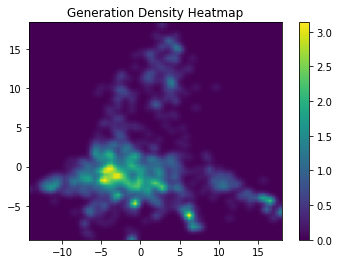

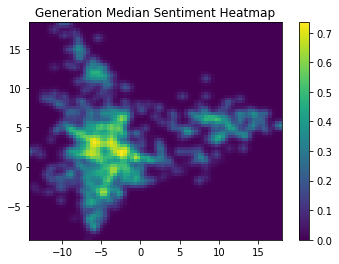

In [133]:
#scatterplot
principalComponents = pca.fit_transform(embed_1)
embed_1 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
fig = px.scatter(embed_1, x="pc1", y="pc2", opacity=.4)
fig.show()

#heatmap
heatmap, xedges, yedges = np.histogram2d(list(embed_1["pc1"]), list(embed_1["pc2"]), bins=bin_size, density=False)
heatmap = gaussian_filter(heatmap, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title("Generation Density Heatmap")
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

# #heatmap with weights as sentiment
# heatmap, xedges, yedges = np.histogram2d(list(embed_1["pc1"]), list(embed_1["pc2"]), bins=bin_size, weights = embed_1_weights, density=True)
# # average = heatmap / np.sum(heatmap)
# heatmap = gaussian_filter(heatmap, sigma=1)
# # print(heatmap)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()

#median sentiment heatmap

# Compute the median of the weights in each bin
median, _, _, _ = binned_statistic_2d(list(embed_1["pc1"]), list(embed_1["pc2"]), embed_1_weights, statistic='median', bins=(bin_size, bin_size))
#set all nans to 0
for y in range(len(median)): 
    for x in range(len(median[y])):
        if pd.isna(median[x][y]):
            median[x][y]  = 0
median = gaussian_filter(median, sigma=1)

# plot the heatmap
plt.clf()
plt.title("Generation Median Sentiment Heatmap")
plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
plt.colorbar()
plt.show()


In [134]:
# from scipy.stats import binned_statistic_2d

# # Compute the median of the weights in each bin
# median, _, _, _ = binned_statistic_2d(list(embed_1["pc1"]), list(embed_1["pc2"]), embed_1_weights, statistic='median', bins=(bin_size, bin_size))
# #set all nans to 0
# for y in range(len(median)): 
#     for x in range(len(median[y])):
#         if pd.isna(median[x][y]):
#             median[x][y]  = 0
# # median = gaussian_filter(median, sigma=2)

# # plot the heatmap
# plt.clf()
# plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
# plt.colorbar()
# plt.show()

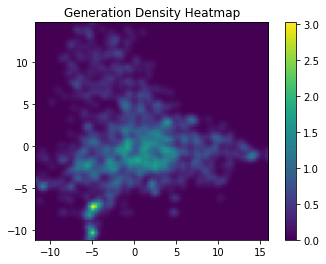

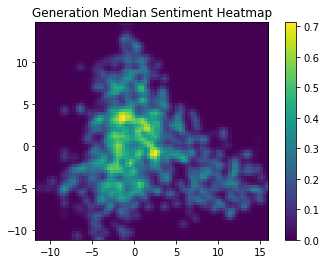

In [135]:
#scatterplot
principalComponents = pca.fit_transform(embed_2)
embed_2 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

fig = px.scatter(embed_2, x="pc1", y="pc2", opacity=.4)
fig.show()

#heatmap with raw numbers 
heatmap, xedges, yedges = np.histogram2d(list(embed_2["pc1"]), list(embed_2["pc2"]), bins=bin_size, density=False)
heatmap = gaussian_filter(heatmap, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title("Generation Density Heatmap")
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

# #heatmap with weights
# heatmap, xedges, yedges = np.histogram2d(list(embed_2["pc1"]), list(embed_2["pc2"]), bins=bin_size, weights = embed_2_weights, density=True)
# # average = heatmap / np.sum(heatmap)
# heatmap = gaussian_filter(heatmap, sigma=1)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()


#median sentiment heatmap
# Compute the median of the weights in each bin
median, _, _, _ = binned_statistic_2d(list(embed_2["pc1"]), list(embed_2["pc2"]), embed_2_weights, statistic='median', bins=(bin_size, bin_size))
#set all nans to 0
for y in range(len(median)): 
    for x in range(len(median[y])):
        if pd.isna(median[x][y]):
            median[x][y]  = 0
median = gaussian_filter(median, sigma=1)

# plot the heatmap
plt.clf()
plt.title("Generation Median Sentiment Heatmap")
plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
plt.colorbar()
plt.show()

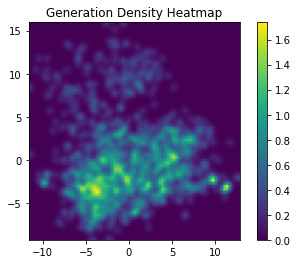

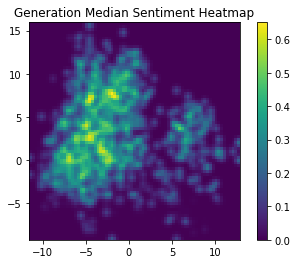

In [136]:
#scatterplot
principalComponents = pca.fit_transform(embed_3)
embed_3 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

fig = px.scatter(embed_3, x="pc1", y="pc2", opacity=.4)
fig.show()

#heatmap with raw numbers
heatmap, xedges, yedges = np.histogram2d(list(embed_3["pc1"]), list(embed_3["pc2"]), bins=bin_size)
heatmap = gaussian_filter(heatmap, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title("Generation Density Heatmap")
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

# #heatmap with weights
# heatmap, xedges, yedges = np.histogram2d(list(embed_3["pc1"]), list(embed_3["pc2"]), bins=bin_size, weights = embed_3_weights, density=False)
# heatmap = gaussian_filter(heatmap, sigma=1)
# # print(heatmap)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()

#median sentiment heatmap
# Compute the median of the weights in each bin
median, _, _, _ = binned_statistic_2d(list(embed_3["pc1"]), list(embed_3["pc2"]), embed_3_weights, statistic='median', bins=(bin_size, bin_size))
#set all nans to 0
for y in range(len(median)): 
    for x in range(len(median[y])):
        if pd.isna(median[x][y]):
            median[x][y]  = 0
median = gaussian_filter(median, sigma=1)

# plot the heatmap
plt.clf()
plt.title("Generation Median Sentiment Heatmap")
plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
plt.colorbar()
plt.show()


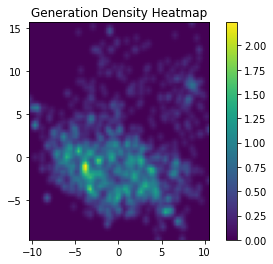

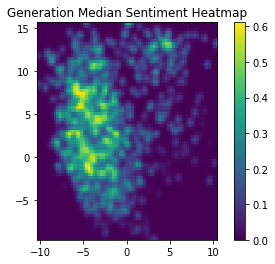

In [137]:
#scatterplot
principalComponents = pca.fit_transform(embed_4)
embed_4 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

fig = px.scatter(embed_4, x="pc1", y="pc2", opacity=.4)
fig.show()

#heatmap with raw numbers
heatmap, xedges, yedges = np.histogram2d(list(embed_4["pc1"]), list(embed_4["pc2"]), bins=bin_size)
heatmap = gaussian_filter(heatmap, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title("Generation Density Heatmap")
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

# #heatmap with weights
# heatmap, xedges, yedges = np.histogram2d(list(embed_4["pc1"]), list(embed_4["pc2"]), bins=bin_size, weights = embed_4_weights, density=False)
# heatmap = gaussian_filter(heatmap, sigma=1)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()

#median sentiment heatmap
# Compute the median of the weights in each bin
median, _, _, _ = binned_statistic_2d(list(embed_4["pc1"]), list(embed_4["pc2"]), embed_4_weights, statistic='median', bins=(bin_size, bin_size))
#set all nans to 0
for y in range(len(median)): 
    for x in range(len(median[y])):
        if pd.isna(median[x][y]):
            median[x][y]  = 0
median = gaussian_filter(median, sigma=1)

# plot the heatmap
plt.clf()
plt.title("Generation Median Sentiment Heatmap")
plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
plt.colorbar()
plt.show()

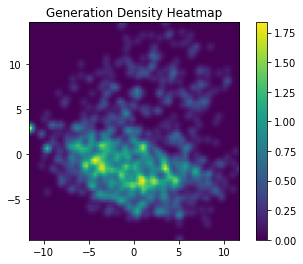

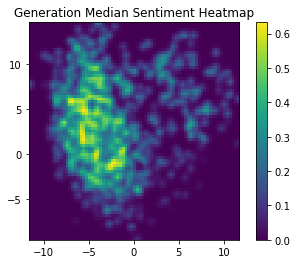

In [138]:
#scatterplot
principalComponents = pca.fit_transform(embed_5)
embed_5 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

fig = px.scatter(embed_5, x="pc1", y="pc2", opacity=.4)
fig.show()

#heatmap
heatmap, xedges, yedges = np.histogram2d(list(embed_5["pc1"]), list(embed_5["pc2"]), bins=bin_size)
heatmap = gaussian_filter(heatmap, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title("Generation Density Heatmap")
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

# #heatmap with weights
# heatmap, xedges, yedges = np.histogram2d(list(embed_5["pc1"]), list(embed_5["pc2"]), bins=bin_size, weights = embed_5_weights, density=False)
# heatmap = gaussian_filter(heatmap, sigma=1)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()

#median sentiment heatmap
# Compute the median of the weights in each bin
median, _, _, _ = binned_statistic_2d(list(embed_5["pc1"]), list(embed_5["pc2"]), embed_5_weights, statistic='median', bins=(bin_size, bin_size))
#set all nans to 0
for y in range(len(median)): 
    for x in range(len(median[y])):
        if pd.isna(median[x][y]):
            median[x][y]  = 0
median = gaussian_filter(median, sigma=1)

# plot the heatmap
plt.clf()
plt.title("Generation Median Sentiment Heatmap")
plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
plt.colorbar()
plt.show()

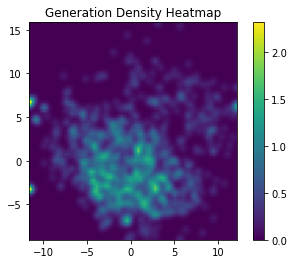

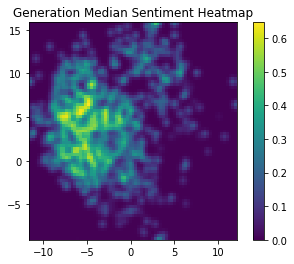

In [139]:
#scatterplot
principalComponents = pca.fit_transform(embed_6)
embed_6 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

fig = px.scatter(embed_6, x="pc1", y="pc2", opacity=.4)
fig.show()

#heatmap
heatmap, xedges, yedges = np.histogram2d(list(embed_6["pc1"]), list(embed_6["pc2"]), bins=bin_size)
heatmap = gaussian_filter(heatmap, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title("Generation Density Heatmap")
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

# #heatmap with weights
# heatmap, xedges, yedges = np.histogram2d(list(embed_6["pc1"]), list(embed_6["pc2"]), bins=bin_size, weights = embed_6_weights, density=False)
# heatmap = gaussian_filter(heatmap, sigma=1)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()

#median sentiment heatmap
# Compute the median of the weights in each bin
median, _, _, _ = binned_statistic_2d(list(embed_6["pc1"]), list(embed_6["pc2"]), embed_6_weights, statistic='median', bins=(bin_size, bin_size))
#set all nans to 0
for y in range(len(median)): 
    for x in range(len(median[y])):
        if pd.isna(median[x][y]):
            median[x][y]  = 0
median = gaussian_filter(median, sigma=1)

# plot the heatmap
plt.clf()
plt.title("Generation Median Sentiment Heatmap")
plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
plt.colorbar()
plt.show()